## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

### 測試方向: 將 BatchNormalization 放在 Activation 之前, BATCH_SIZE: 256, 512, 1024 在有呈現overfitting狀況下, 搭配使用L1、L2 Regularization,  比較訓練效果看是否能更好?

In [9]:
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 BN layer
"""
# 模型定義函數_增加兩個參數: regularization, ratio !!
def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == "l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
            else:
                x = BatchNormalization()(x)
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
    elif regularization == "l2":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
            else:
                x = BatchNormalization()(x)
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)       
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [256, 512, 1024]
MOMENTUM = 0.95
REGULARIZATION = ["l1", "l2"]
EXP = [1e-4, 1e-12]

In [11]:
import tensorflow as tf

results = {}

for bts in BATCH_SIZE:
    for regularization in REGULARIZATION:
        for regulizer_ratio in EXP:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print(f"BATCH_SIZE: {bts}, Regularization: {regularization}, Ratio: {regulizer_ratio}")
            model = build_mlp(input_shape=x_train.shape[1:], regularization=regularization, ratio=regulizer_ratio)
            model.summary()
            optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bts, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

            exp_name_tag = "BATCH_SIZE: %s, Regularization: %s, Ratio: %s" % (str(bts), regularization, str(regulizer_ratio))
            results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


BATCH_SIZE: 256, Regularization: l1, Ratio: 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_nor

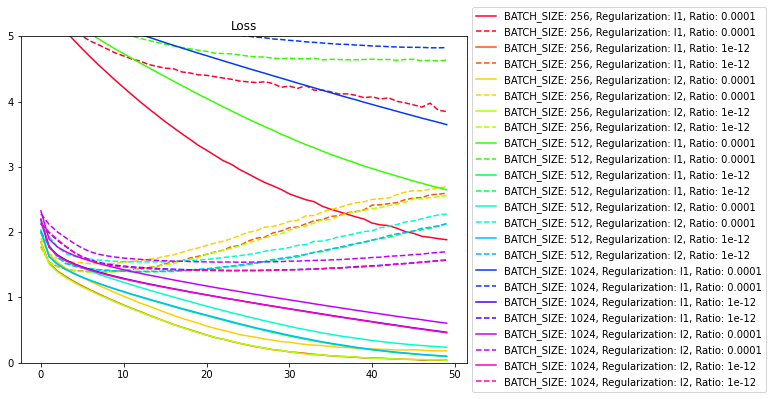

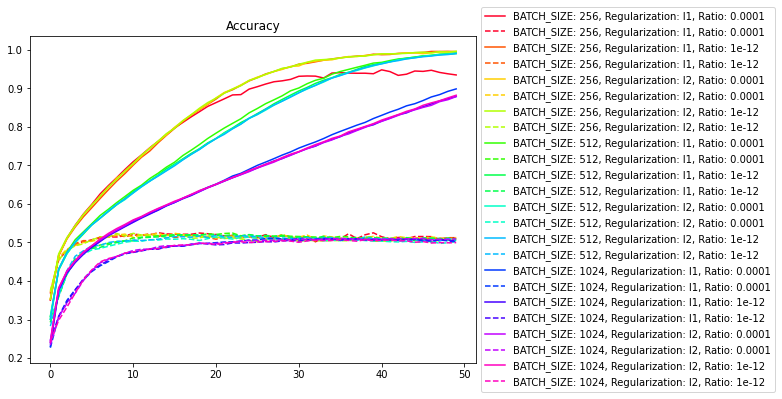

In [12]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

NUM_COLORS = 12

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()